In [105]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches
from IPython.display import display



In [106]:
USE_GPU = True
TRAIN = False

In [107]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1724347288.544137    4139 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724347288.545411    4139 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724347288.547176    4139 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724347288.548820    4139 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [108]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 256
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
LEARNING_RATE = 0.002
EPOCHS = 55
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [109]:
data = np.load("./data/language_phonemes.npz", allow_pickle=True)
language_phonemes_selected = data["language_phonemes_selected"]
language_names_selected = data["language_names_selected"]

# pad to IMAGE_SIZE * IMAGE_SIZE
X = language_phonemes_selected.copy()
X = np.hstack([X, np.full((X.shape[0], IMAGE_SIZE - X.shape[1], X.shape[2]), 0)])
X = np.dstack([X, np.full((X.shape[0], X.shape[1], IMAGE_SIZE - X.shape[2]), 0)])
X = np.expand_dims(X, axis=3)

assert language_phonemes_selected.shape[0] == language_names_selected.shape[0]
(language_phonemes_selected.shape, language_names_selected.shape, X.shape)

((2740, 29, 24), (2740,), (2740, 32, 32, 1))

In [110]:
shape = X.shape[1:]
width = shape[0]

print(shape)

critic = Sequential(
    [
        Input(shape=shape),
        layers.Conv2D(IMAGE_SIZE, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 16, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(1, kernel_size=2, strides=1, padding="valid"),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

(32, 32, 1)


Model: "critic"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d_70 (Conv2D)              ‚îÇ (None, 16, 16, 32)     ‚îÇ           160 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu_70 (LeakyReLU)      ‚îÇ (None, 16, 16, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_71 (Conv2D)              ‚îÇ (None, 8, 8, 64)       ‚îÇ         8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu_71 (LeakyReLU)      ‚îÇ (None, 8, 8, 64)       ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_56 (Dropout)            ‚îÇ (None, 8, 8, 64)       ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_72 (Conv2D)              ‚îÇ (None, 4, 4, 128)      ‚îÇ        32,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu_72 (LeakyReLU)      ‚îÇ (None, 4, 4, 128)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_57 (Dropout)            ‚îÇ (None, 4, 4, 128)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_73 (Conv2D)              ‚îÇ (None, 2, 2, 256)      ‚îÇ       131,328 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu_73 (LeakyReLU)      ‚îÇ (None, 2, 2, 256)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_58 (Dropout)            ‚îÇ (None, 2, 2, 256)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ

 Total params: 699,489 (2.67 MB)

 Trainable params: 699,489 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 8, kernel_size=4, strides=1, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        # layers.Conv2DTranspose(
        #     IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        # ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        # layers.Dropout(0.3),
        # layers.Conv2D(
        #     IMAGE_SIZE * 2, kernel_size=3, strides=1, padding="same", use_bias=False
        # ),
        # layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=1, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            CHANNELS, kernel_size=4, strides=2, padding="same", activation="sigmoid"
        ),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ reshape_7 (Reshape)             ‚îÇ (None, 1, 1, 1024)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_transpose_35             ‚îÇ (None, 4, 4, 256)      ‚îÇ     4,194,304 ‚îÇ
‚îÇ (Conv2DTranspose)               ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_60 (Dropout)            ‚îÇ (None, 4, 4, 256)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_76 (Conv2D)              ‚îÇ (None, 4, 4, 256)      ‚îÇ       589,824 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_28          ‚îÇ (None, 4, 4, 256)      ‚îÇ         1,024 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu_75 (LeakyReLU)      ‚îÇ (None, 4, 4, 256)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_61 (Dropout)            ‚îÇ (None, 4, 4, 256)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_77 (Conv2D)              ‚îÇ (None, 4, 4, 128)      ‚îÇ       294,912 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_29          ‚îÇ (None, 4, 4, 128)      ‚îÇ           512 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu_76 (LeakyReLU)      ‚îÇ (None, 4, 4, 128)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_transpose_36             ‚îÇ (None, 8, 8, 64)      

 Total params: 5,280,001 (20.14 MB)

 Trainable params: 5,279,105 (20.14 MB)

 Non-trainable params: 896 (3.50 KB)

In [112]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [113]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [114]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images.numpy()
            plt.figure(figsize=(IMAGE_SIZE, IMAGE_SIZE))

            for i in range(10):
                _ = plt.subplot(1, 10, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

In [115]:

if TRAIN:
    wgangp.fit(
        X,
        epochs=EPOCHS,
        steps_per_epoch=3,
        callbacks=[
            ImageGenerator(num_img=10, latent_dim=Z_DIM),
        ],
    )

(18, 32, 32, 1)
(1, 32, 32, 1)


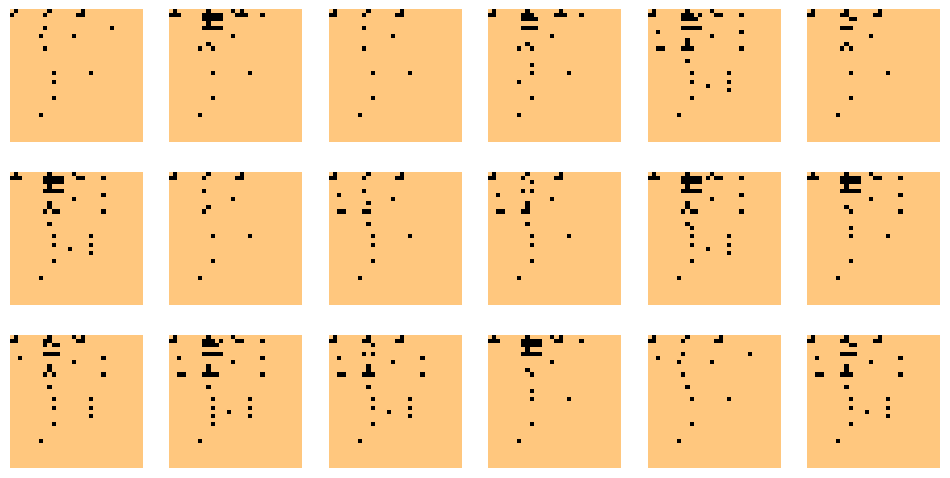

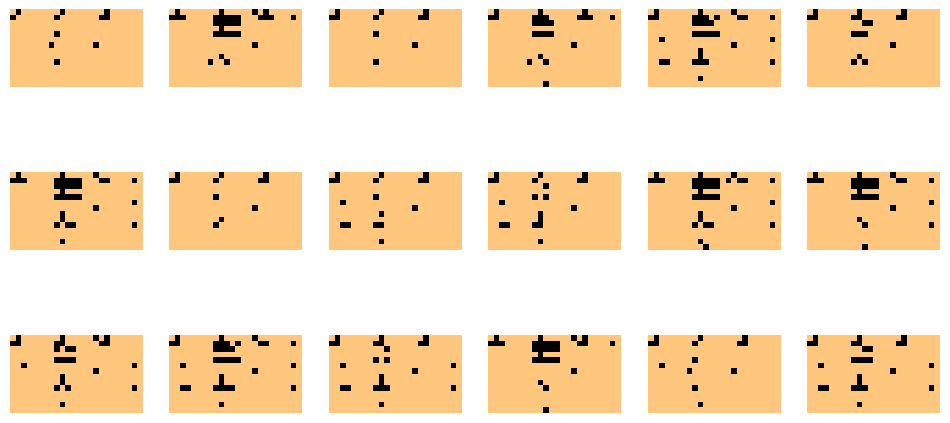

In [124]:
if TRAIN:
    
    noise = np.random.normal(size=(18, 1024))
    generated_languages = generator.predict(noise)

    np.savez_compressed(
        "./data/language_phonemes_all.npz",
        generated_languages=generated_languages,
    )

else:
    data = np.load("./data/language_phonemes_all.npz", allow_pickle=True)
    generated_languages = data["generated_languages"]

    print(generated_languages.shape)

    # normalise
    generated_languages = (generated_languages-np.min(generated_languages))/(np.max(generated_languages)-np.min(generated_languages))
    # sigmoid
    generated_languages = np.where(generated_languages > 0.5, np.ones(generated_languages.shape), np.zeros(generated_languages.shape))


display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(12, 6))

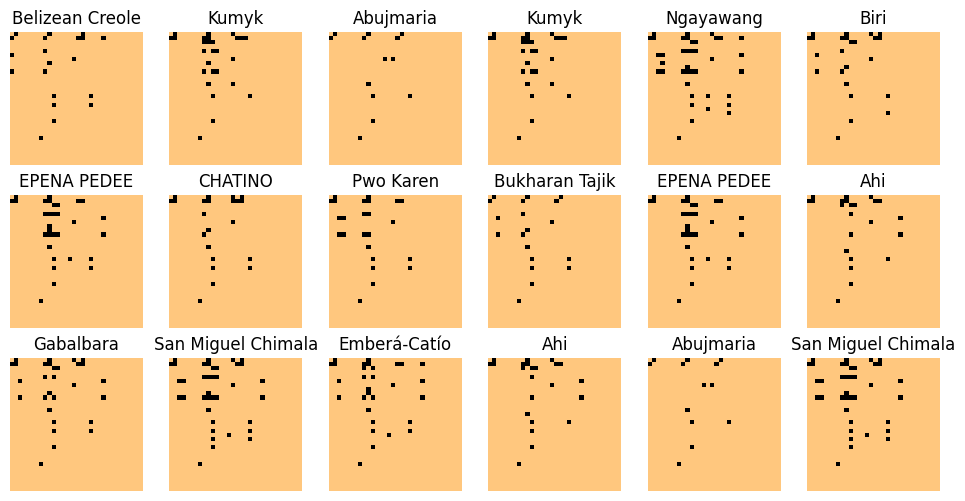

In [117]:
# find closest matches

closest_idx, closest = get_closest_matches(X, generated_languages, n=18)
closest_language_names = np.take(language_names_selected, closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))

In [126]:
# load the phoneme table dataframes

cons_pl_tbl_df = pd.read_csv(
    "./data/consonants_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
    on_bad_lines="warn",
)
display(cons_pl_tbl_df)
print(cons_pl_tbl_df.shape)

cons_npl_tbl_df = pd.read_csv(
    "./data/consonants_non_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(cons_npl_tbl_df)
print(cons_npl_tbl_df.shape)


cons_coart_tbl_df = pd.read_csv(
    "./data/consonants_coarticulated.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(cons_coart_tbl_df)
print(cons_coart_tbl_df.shape)


vowels_tbl_df = pd.read_csv(
    "./data/vowels.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(vowels_tbl_df)
print(vowels_tbl_df.shape)

Bilabial Bilabial_v Labiodental Labiodental_v  \
Nasal                        mÃ•          m          …±Ãä             …±   
Plosive                       p          b          pÃ™            bÃ™   
Sibilant affricate          NaN        NaN         NaN           NaN   
Non-sibilant affricate       p…∏         bŒ≤         pÃ™f           bÃ™v   
Sibilant fricative          NaN        NaN         NaN           NaN   
Non-sibilant fricative        …∏          Œ≤           f             v   
Approximant                                                         ã   
Tap/flap                                ‚±±Ãü                         ‚±±   
Trill                         ôÃ•           ô                             
Fricative                     …∏          Œ≤           f             v   
Lateral affricate           NaN        NaN         NaN           NaN   
Lateral fricative           NaN        NaN         NaN           NaN   
Lateral approximant         NaN        NaN         NaN           NaN   
Lateral tap/flap            NaN        NaN         NaN           NaN   

                       Linguolabial Linguolabial_v Dental Dental_v Alveolar  \
Nasal                                           nÃº                       nÃ•   
Plosive                          tÃº             dÃº                        t   
Sibilant affricate              NaN            NaN                       ts   
Non-sibilant affricate                                tÃ™Œ∏      dÃ™√∞     t…πÃùÃä   
Sibilant fricative              NaN            NaN                        s   
Non-sibilant fricative           Œ∏Ãº             √∞Ãº      Œ∏        √∞       Œ∏Ã†   
Approximant                                                                   
Tap/flap                                        …æÃº                       …æÃ•   
Trill                                                                    rÃ•   
Fricative                                               Œ∏        √∞        s   
Lateral affricate                                                        t…¨   
Lateral fricative                                                         …¨   
Lateral approximant                                                           
Lateral tap/flap                                                         …∫Ã•   

                       Alveolar_v  ... Palatal Palatal_v Velar Velar_v Uvular  \
Nasal                           n  ...      …≤Ãä         …≤    ≈ãÃä       ≈ã     …¥Ã•   
Plosive                         d  ...       c         …ü     k       …°      q   
Sibilant affricate             dz  ...      t…ï        d ë   NaN     NaN    NaN   
Non-sibilant affricate        d…πÃù  ...      c√ß        …ü ù    kx      …°…£     qœá   
Sibilant fricative              z  ...       …ï          ë   NaN     NaN    NaN   
Non-sibilant fricative         √∞Ã†  ...       √ß          ù     x       …£      œá   
Approximant                     …π  ...                 j             …∞          
Tap/flap                        …æ  ...                                          
Trill                           r  ...                     NaN     NaN      ÄÃ•   
Fricative                       z  ...       √ß          ù     x       …£      œá   
Lateral affricate              d…Æ  ...      cùºÜ       …ü éÃù    kùºÑ     …° üÃù          
Lateral fricative               …Æ  ...       ùºÜ         éÃù     ùºÑ       üÃù          
Lateral approximant             l  ...                  é              ü          
Lateral tap/flap                …∫  ...                 éÃÜ             üÃÜ          

                       Uvular_v Pharyngeal Pharyngeal_v Glottal Glottal_v  
Nasal                         …¥        NaN          NaN     NaN       NaN  
Plosive                       …¢                     NaN        î       NaN  
Sibilant affricate          NaN        NaN          NaN     NaN       NaN  
Non-sibilant affricate       …¢ Å          ° ú            ° ¢       îh            
Sibilant fricative          N

(14, 24)


0     1      2      3    4   5   6   7
Ejective Stop         p º    t º      à º     c º   k º  q º   ° º    
Ejective Fricative    f º    Œ∏ º     s º      É º    Ç º  …ï º  x º  œá º
Ejective Affricate   ts º  tÃ† É º     à Ç º    kx º  qœá º            
Ejective Lateral      …¨ º   t…¨ º  c éÃùÃä º  k üÃùÃä º                 
Click                 k ò    k«Ä     k«É     k«Ç   k«Å            
Implosive Voiced       …ì     …ó      ·∂ë       Ñ    …†    õ        
Implosive Voiceless   …ìÃ•    …óÃ•     ·∂ëÃ•      ÑÃ•   …†Ãä   õÃ•

(7, 8)


Labial‚Äìalveolar Labial‚Äìalveolar_v Labial‚Äìretroflex  \
Nasal                                               nÕ°m                    
Plosive                           tÕ°p               dÕ°b               àÕ°p   
Fricative/approximant                                                      
Lateral approximant                                                        
Implosive                                                                  
Ejective                                           tÕ°p º                    

                      Labial‚Äìretroflex_v Labial‚Äìpalatal Labial‚Äìpalatal_v  \
Nasal                                …≥Õ°m                                   
Plosive                              …ñÕ°b                                   
Fricative/approximant                                …•Ãä                …•   
Lateral approximant                                                        
Implosive                                                                  
Ejective                                                                   

                      Labial‚Äìvelar Labial‚Äìvelar_v Labial‚Äìuvular  \
Nasal                                         ≈ãÕ°m                 
Plosive                        kÕ°p            …°Õ°b           qÕ°p   
Fricative/approximant             ç              w                 
Lateral approximant                                               
Implosive                    …†ÃäÕú…ìÃ•            …†Õ°…ì                 
Ejective                                                          

                      Labial‚Äìuvular_v Velarized alveolar Velarized alveolar_v  \
Nasal                                                                           
Plosive                                                                         
Fricative/approximant                                                           
Lateral approximant                                                         …´   
Implosive                                                                       
Ejective                                                                        

                      Uvular‚Äìepiglottal Uvular‚Äìepiglottal_v Palatal-velar  \
Nasal                                                                       
Plosive                             qÕ° °                                     
Fricative/approximant                                                   …ß   
Lateral approximant                                                         
Implosive                                                                   
Ejective                                                                    

                      Palatal-velar_v  
Nasal                                  
Plosive                                
Fricative/approximant                  
Lateral approximant                    
Implosive                              
Ejective

(6, 16)


Front unrounded Front rounded Near-front unrounded  \
Close                    i             y                        
Near-close                                                  …™   
Close-mid                e             √∏                        
Mid                     eÃû            √∏Ãû                        
Open-mid                 …õ             ≈ì                        
Near-open                √¶                                      
Open                     a             …∂                        

           Near-front rounded Central unrounded Central rounded  \
Close                                         …®                â   
Near-close                   è                                     
Close-mid                                     …ò               …µ   
Mid                                           …ô                   
Open-mid                                      …ú               …û   
Near-open                   …ê                                     
Open                                          √§                   

           Near-back unrounded Near-back rounded Back unrounded Back rounded  
Close                                                         …Ø            u  
Near-close                                      ä                              
Close-mid                                                     …§            o  
Mid                                                          …§Ãû           oÃû  
Open-mid                                                       å            …î  
Near-open                                                                     
Open                                                          …ë            …í

(7, 10)


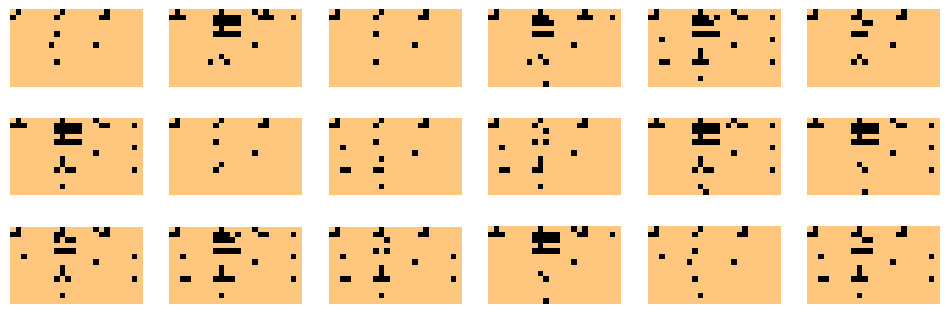

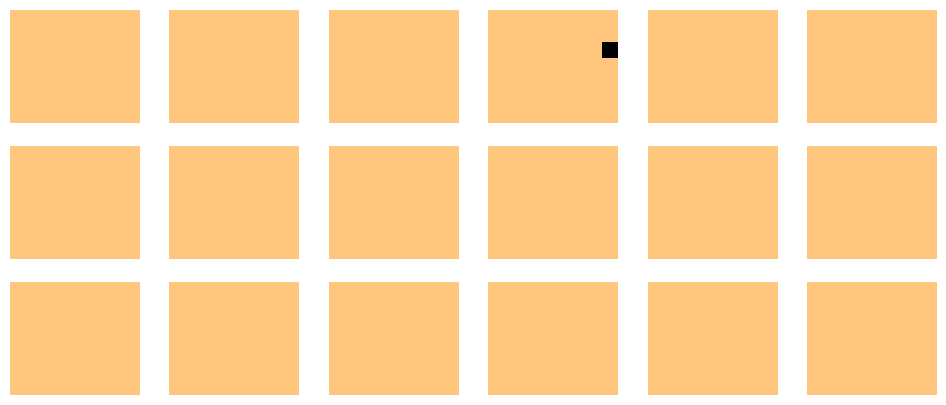

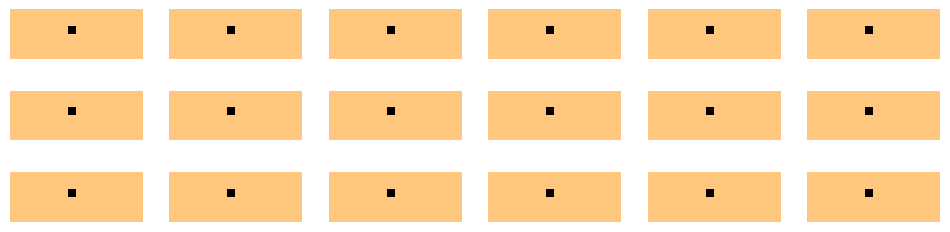

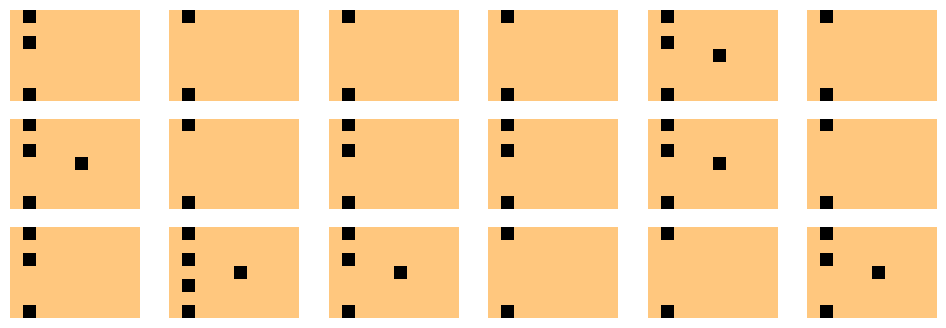

((18, 14, 24, 1), (18, 7, 8, 1), (18, 6, 16, 1), (18, 7, 10, 1))

In [136]:
generated_cons_pl = generated_languages[:, 0:14, 0:24 :]
generated_cons_npl = generated_languages[:, 15:22, 0:8 :]
generated_vowels = generated_languages[:, 15:22, 9:19 :]
generated_cons_coart = generated_languages[:, 23:29, 0:16 :]


display_rows(generated_cons_pl, cmap="copper_r", r=3, c=6, size=(12, 4))
display_rows(generated_cons_npl, cmap="copper_r", r=3, c=6, size=(12, 5))
display_rows(generated_cons_coart, cmap="copper_r", r=3, c=6, size=(12, 3))
display_rows(generated_vowels, cmap="copper_r", r=3, c=6, size=(12, 4))

generated_cons_pl.shape, generated_cons_npl.shape, generated_cons_coart.shape, generated_vowels.shape

In [159]:
for idx, _ in enumerate(generated_languages):
    tbl = cons_pl_tbl_df.replace(np.nan, "*").replace("", "*")
    lang = np.squeeze(generated_cons_pl[idx])
    phonemes = np.where(lang > 0, tbl, np.full(lang.shape, "_")).astype(str)
    new_tbl = np.char.add(
        np.char.add(phonemes[:,0::2], np.full(phonemes[:,0::2].shape, " ")),
        phonemes[:,1::2]
    )
    new_cols = cons_pl_tbl_df.columns[0::2]
    phoneme_tbl = pd.DataFrame(
        new_tbl, 
        index=cons_pl_tbl_df.index, 
        columns=new_cols
    )
    display(phoneme_tbl)

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p _         _ _          _ _    _ _      t _   
Sibilant affricate          _ _         _ _          _ _    _ _      _ _   
Non-sibilant affricate      _ _         _ _          _ _    _ _      _ _   
Sibilant fricative          _ _         _ _          _ _    _ _      s _   
Non-sibilant fricative      _ _         _ _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ *      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ _   
Trill                       _ _         _ _          _ _    _ _      _ _   
Fricative                   _ _         _ _          _ _    _ _      s _   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ _   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ _   _ ≈ã    _ _        _ _   
Plosive                         _ _       _ _     _ _   k …°    _ _        _ _   
Sibilant affricate              _ _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative              _ _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                       _ _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                    _ _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     _ _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  _ _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b        pÃ™ _          _ _    _ _      t d   
Sibilant affricate          _ _         _ _          _ _    _ _    ts dz   
Non-sibilant affricate      _ _         _ _          _ _    _ _    _ d…πÃù   
Sibilant fricative          _ _         _ _          _ _    _ _      s z   
Non-sibilant fricative      _ _         _ _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ _   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         _ _          _ _    _ √∞      _ _   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ _   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ …≤   _ ≈ã    _ _        _ _   
Plosive                         * *        à _     _ _   k …°    q _        _ _   
Sibilant affricate          tÃ† É dÃ† í      t Ç _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative               É  í        Ç _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                        É _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                     î _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     _ _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  _ _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b         _ _          _ _    _ _      t _   
Sibilant affricate          _ _         _ _          _ _    _ _      _ _   
Non-sibilant affricate      _ _         _ _          _ _    _ _      _ _   
Sibilant fricative          _ _         _ _          _ _    _ _      s _   
Non-sibilant fricative      _ _         _ _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ _   
Trill                       _ _         _ _          _ _    _ _      _ _   
Fricative                   _ _         _ _          _ _    _ _      s _   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ _   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ _   _ ≈ã    _ _        _ _   
Plosive                         _ _       _ _     _ _   k …°    _ _        _ _   
Sibilant affricate              _ _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative              _ _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                       _ _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                    _ _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     _ _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  _ _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b         _ _          _ _    _ _      t d   
Sibilant affricate          _ _         _ _          _ _    _ _    ts dz   
Non-sibilant affricate      _ _         _ _          _ _    _ _      _ _   
Sibilant fricative          _ _         _ _          _ _    _ _      s z   
Non-sibilant fricative      _ _         _ _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ _   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         _ _          _ _    _ √∞      _ _   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ _   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ _   _ ≈ã    _ _        _ _   
Plosive                         * _       _ _     _ _   k …°    q _        _ _   
Sibilant affricate          tÃ† É dÃ† í       _ _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative               É  í       _ _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                        É _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                * _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                     î _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     _ _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  _ _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b         _ _          _ _    _ _      t d   
Sibilant affricate          _ _         _ _          _ _    _ _    ts dz   
Non-sibilant affricate      _ _         _ _          _ _    _ _      _ _   
Sibilant fricative          _ _         _ _          _ _    _ _      s z   
Non-sibilant fricative      _ _         f _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ …æ   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         f v          _ _    _ _      s z   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ l   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ …≤   _ _    _ _        _ _   
Plosive                         * _        à _     _ _   k …°    _ _        _ _   
Sibilant affricate          tÃ† É dÃ† í       _ _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative               É  í        Ç _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                        É _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                     î _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     h _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  h _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b         _ _          _ _    _ _      t d   
Sibilant affricate          _ _         _ _          _ _    _ _      _ _   
Non-sibilant affricate      _ _         _ _          _ _    _ _      _ _   
Sibilant fricative          _ _         _ _          _ _    _ _      s z   
Non-sibilant fricative      _ _         _ _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ _   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         _ _          _ _    _ _      s _   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ _   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ _   _ ≈ã    _ _        _ _   
Plosive                         _ _       _ _     _ _   k …°    _ _        _ _   
Sibilant affricate          tÃ† É dÃ† í       _ _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative               É _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                        É _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                    _ _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     _ _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  _ _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b        pÃ™ _          _ _    _ _      t d   
Sibilant affricate          _ _         _ _          _ _    _ _    ts dz   
Non-sibilant affricate      _ _         _ _          _ _    _ _    _ d…πÃù   
Sibilant fricative          _ _         _ _          _ _    _ _      s z   
Non-sibilant fricative      _ _         _ _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ …æ   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         _ _          _ _    _ _      s _   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ l   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ …≤   _ _    _ _        _ _   
Plosive                         * *        à _     _ _   k …°    _ _        _ _   
Sibilant affricate          tÃ† É dÃ† í      t Ç _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative               É  í        Ç _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                        É  í       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                     î _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     h _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  h _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b         _ _          _ _    _ _      t _   
Sibilant affricate          _ _         _ _          _ _    _ _      _ _   
Non-sibilant affricate      _ _         _ _          _ _    _ _      _ _   
Sibilant fricative          _ _         _ _          _ _    _ _      s _   
Non-sibilant fricative      _ _         _ _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ _   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         _ _          _ _    _ _      s _   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ _   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ _   _ ≈ã    _ _        _ _   
Plosive                         _ _       _ _     _ _   k …°    _ _        _ _   
Sibilant affricate              _ _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative              _ _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                       _ _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                    _ _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     _ _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  _ _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b         _ _          _ _    _ _      t _   
Sibilant affricate          _ _         _ _          _ _    _ _      _ _   
Non-sibilant affricate      _ _         _ _          _ _    _ _      _ _   
Sibilant fricative          _ _         _ _          _ _    _ _      s _   
Non-sibilant fricative      _ _         f _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ …æ   
Trill                       _ _         _ _          _ _    _ _      _ _   
Fricative                   _ _         f v          _ _    _ _      s z   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ l   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ _   _ ≈ã    _ _        _ _   
Plosive                         _ _       _ _     _ _   k …°    _ _        _ _   
Sibilant affricate              _ _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative              _ _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                       _ _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                    _ _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     _ _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  _ _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b         _ _          _ _    _ _      t _   
Sibilant affricate          _ _         _ _          _ _    _ _      _ _   
Non-sibilant affricate      _ _         _ _          _ _    _ _      _ _   
Sibilant fricative          _ _         _ _          _ _    _ _      s _   
Non-sibilant fricative      _ _         f _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ …æ   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         f v          _ _    _ _      s z   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ l   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ _   _ ≈ã    _ _        _ _   
Plosive                         _ _       _ _     _ _   k …°    _ _        _ _   
Sibilant affricate            tÃ† É _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative               É _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                       _ _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                    _ _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     _ _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  _ _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b        pÃ™ _          _ _    _ _      t d   
Sibilant affricate          _ _         _ _          _ _    _ _    ts dz   
Non-sibilant affricate      _ _         _ _          _ _    _ _    _ d…πÃù   
Sibilant fricative          _ _         _ _          _ _    _ _      s z   
Non-sibilant fricative      _ _         _ _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ …æ   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         _ _          _ _    _ _      s _   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ l   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ …≤   _ _    _ _        _ _   
Plosive                         * *        à _     c _   k …°    _ _        _ _   
Sibilant affricate          tÃ† É dÃ† í      t Ç _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative               É  í        Ç _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                        É  í       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                * _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                     î _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     h _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  h _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b        pÃ™ _          _ _    _ _      t d   
Sibilant affricate          _ _         _ _          _ _    _ _    ts dz   
Non-sibilant affricate      _ _         _ _          _ _    _ _    _ d…πÃù   
Sibilant fricative          _ _         _ _          _ _    _ _      s z   
Non-sibilant fricative      _ _         _ _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ _   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         _ _          _ _    _ _      _ _   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ _   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ …≤   _ _    _ _        _ _   
Plosive                         * *        à _     _ _   k …°    _ _        _ _   
Sibilant affricate          tÃ† É dÃ† í      t Ç _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative               É  í        Ç _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                        É _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                * _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                     î _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     h _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  h _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b         _ _          _ _    _ _      t d   
Sibilant affricate          _ _         _ _          _ _    _ _     ts _   
Non-sibilant affricate      _ _         _ _          _ _    _ _      _ _   
Sibilant fricative          _ _         _ _          _ _    _ _      s z   
Non-sibilant fricative      _ _         f _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ …æ   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         _ _          _ _    _ _      s _   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ l   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ …≤   _ ≈ã    _ _        _ _   
Plosive                         _ _       _ _     _ _   k …°    _ _        _ _   
Sibilant affricate          tÃ† É dÃ† í       _ _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative               É  í       _ _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                        É _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                    _ _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     h _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  h _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b         _ _          _ _    _ _      t d   
Sibilant affricate          _ _         _ _          _ _    _ _    ts dz   
Non-sibilant affricate      _ _         _ _          _ _    _ _      _ _   
Sibilant fricative          _ _         _ _          _ _    _ _      s z   
Non-sibilant fricative      _ _         f _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ …æ   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         f v          _ _    _ _      s z   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ l   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ …≤   _ _    _ _        _ _   
Plosive                         * _        à _     _ _   k …°    _ _        _ _   
Sibilant affricate          tÃ† É dÃ† í       _ _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative               É  í        Ç _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                        É  í       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                     î _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     h _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  h _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b         _ _          _ _    _ _      t d   
Sibilant affricate          _ _         _ _          _ _    _ _      _ _   
Non-sibilant affricate      _ _         _ _          _ _    _ _      _ _   
Sibilant fricative          _ _         _ _          _ _    _ _      s _   
Non-sibilant fricative      _ _         f _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ …æ   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         f v          _ _    _ _      s z   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ l   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ _   _ ≈ã    _ _        _ _   
Plosive                         _ _       _ _     _ _   k …°    _ _        _ _   
Sibilant affricate            tÃ† É _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative               É _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                        É _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                    _ _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     h _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  h _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b        pÃ™ _          _ _    _ _      t d   
Sibilant affricate          _ _         _ _          _ _    _ _    ts dz   
Non-sibilant affricate      _ _         _ _          _ _    _ _    _ d…πÃù   
Sibilant fricative          _ _         _ _          _ _    _ _      s z   
Non-sibilant fricative      _ _         _ _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ _   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         _ _          _ _    _ _      _ _   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ _   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ …≤   _ ≈ã    _ _        _ _   
Plosive                         * *        à _     _ _   k …°    _ _        _ _   
Sibilant affricate          tÃ† É dÃ† í      t Ç _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative               É  í        Ç _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                        É _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                * _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                     î _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     _ _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  _ _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b         _ _          _ _    _ _      t _   
Sibilant affricate          _ _         _ _          _ _    _ _      _ _   
Non-sibilant affricate      _ _         _ _          _ _    _ _      _ _   
Sibilant fricative          _ _         _ _          _ _    _ _      s _   
Non-sibilant fricative      _ _         f _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ *      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ _   
Trill                       _ _         _ _          _ _    _ _      _ _   
Fricative                   _ _         _ _          _ _    _ _      s _   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ l   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ _   _ ≈ã    _ _        _ _   
Plosive                         _ _       _ _     _ _   k …°    _ _        _ _   
Sibilant affricate              _ _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative              _ _       _ _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                       _ _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                    _ _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     _ _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  _ _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _

Bilabial Labiodental Linguolabial Dental Alveolar  \
Nasal                       _ m         _ _          _ _    _ _      _ n   
Plosive                     p b         _ _          _ _    _ _      t d   
Sibilant affricate          _ _         _ _          _ _    _ _      _ _   
Non-sibilant affricate      _ _         _ _          _ _    _ _      _ _   
Sibilant fricative          _ _         _ _          _ _    _ _      s z   
Non-sibilant fricative      _ _         f _          _ _    _ _      _ _   
Approximant                 _ _         _ _          _ _    _ _      _ _   
Tap/flap                    _ _         _ _          _ _    _ _      _ …æ   
Trill                       _ _         _ _          _ _    _ _      _ r   
Fricative                   _ _         f v          _ _    _ _      s z   
Lateral affricate           _ _         _ _          _ _    _ _      _ _   
Lateral fricative           _ _         _ _          _ _    _ _      _ _   
Lateral approximant         _ _         _ _          _ _    _ _      _ l   
Lateral tap/flap            _ _         _ _          _ _    _ _      _ _   

                       Postalveolar Retroflex Palatal Velar Uvular Pharyngeal  \
Nasal                           _ _       _ _     _ _   _ ≈ã    _ _        _ _   
Plosive                         _ _       _ _     _ _   k …°    _ _        _ _   
Sibilant affricate          tÃ† É dÃ† í       _ _     _ _   _ _    _ _        _ _   
Non-sibilant affricate          _ _       _ _     _ _   _ _    _ _        _ _   
Sibilant fricative               É  í       _ _     _ _   _ _    _ _        _ _   
Non-sibilant fricative          _ _       _ _     _ _   _ _    _ _        _ _   
Approximant                     _ _       _ _     _ j   _ _    _ _        _ _   
Tap/flap                        _ _       _ _     _ _   _ _    _ _        _ _   
Trill                           _ _       _ _     _ _   _ _    _ _        _ _   
Fricative                        É _       _ _     _ _   _ _    _ _        _ _   
Lateral affricate               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral fricative               _ _       _ _     _ _   _ _    _ _        _ _   
Lateral approximant             _ _       _ _     _ _   _ _    _ _        _ _   
Lateral tap/flap                _ _       _ _     _ _   _ _    _ _        _ _   

                       Glottal  
Nasal                      _ _  
Plosive                    _ _  
Sibilant affricate         _ _  
Non-sibilant affricate     _ _  
Sibilant fricative         _ _  
Non-sibilant fricative     h _  
Approximant                _ _  
Tap/flap                   _ _  
Trill                      _ _  
Fricative                  h _  
Lateral affricate          _ _  
Lateral fricative          _ _  
Lateral approximant        _ _  
Lateral tap/flap           _ _